# Анализ поведения пользователей в мобильном приложении

Необходимо разобраться, как ведут себя пользователи мобильного приложения стартапа, который продаёт продукты питания.

Для этого следует изучить воронку продаж и узнать, как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько застревает на предыдущих шагах и на каких именно.

После этого нужно исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Поэтому договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимр выяснить, какой шрифт лучше?

у нас есть данные:

Каждая запись в логе — это действие пользователя, или событие.

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Цель исследования**:
- разобраться, как ведут себя пользователи мобильного приложения стартапа, который продаёт продукты питания.

 
**Таким образом, исследование пройдёт в несколько этапов:**
 1. Обзор данных
 2. Предобработка данных
 3. Исследовательский анализ данных
 4. Анализ воронки событий
 5. Анализ A/B-теста
 6. Формулирование вывода

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math as mth
import scipy.stats as stats
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
from io import BytesIO
import warnings
warnings.filterwarnings("ignore")


In [3]:
import plotly.io as pio
pio.renderers.default = "png"

## Загрузка и подготовка данных к анализу

### Обзор данных

In [4]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t' )

In [5]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Количество уникальных значений в столбцах:

In [7]:
data.nunique()

EventName              5
DeviceIDHash        7551
EventTimestamp    176654
ExpId                  3
dtype: int64

Вывод: пропущенные значения отсутствуют, но присутствуют явные дубликаты, тип столбца EventTimestamp не соответствует описанию. Данные необходимо обработать до начала проведения исследовательского анализа.

### Предобработка данных

In [8]:
#data.columns = ['event_name', 'device_id_hash', 'event_time_stamp', 'group'] 

In [9]:
data = data.rename(columns={'EventName': 'event_name',
                     'DeviceIDHash': 'device_id_hash',
                     'EventTimestamp': 'event_time_stamp',
                     'ExpId': 'group'})

Приведем тип столбца event_time_stamp к правильному

In [10]:
data['event_time_stamp'] = pd.to_datetime(data['event_time_stamp'], unit='s') 

Добавим отдельный столбец с датой события

In [11]:
data['event_date'] =  pd.to_datetime(data['event_time_stamp']).dt.date 

In [12]:
print("\nКоличество явных дубликатов:", data.duplicated().sum())


Количество явных дубликатов: 413


Удалим из датасета явные дубликаты:

In [13]:
data = data.drop_duplicates().reset_index(drop=True)

In [14]:
print("\nКоличество явных дубликатов:", data.duplicated().sum())


Количество явных дубликатов: 0


In [15]:
data.head()

,event_name,device_id_hash,event_time_stamp,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        243713 non-null  object        
 1   device_id_hash    243713 non-null  int64         
 2   event_time_stamp  243713 non-null  datetime64[ns]
 3   group             243713 non-null  int64         
 4   event_date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


Посмотри есть ли в данных пользователи, которые состоят в нескольких группах одновременно:

In [17]:
visitors_groups = data.groupby('device_id_hash')['group'].nunique()
sum(visitors_groups > 1) 

0

Таких пользователей нет

## Исследовательский анализ данных

### Общее количество событий в логе

In [18]:
total_events = len(data['event_name'])
print("Количество событий в логах:", total_events)

Количество событий в логах: 243713


### Общее количество пользователей в логе

In [19]:
total_users = data['device_id_hash'].nunique()
print("Количество пользователей в логах:", total_users)

Количество пользователей в логах: 7551


### Среднее количество событий на одного пользователя

In [20]:
print("Среднее количество событий на одного пользователя:", total_events / total_users)

Среднее количество событий на одного пользователя: 32.27559263673685


### Временной период данных

In [21]:
data['event_date'].agg(['min', 'max'])

min    2019-07-25
max    2019-08-07
Name: event_date, dtype: object

Мы располагаем данными за период с 25 июля 2019 года по 7 августа 2019

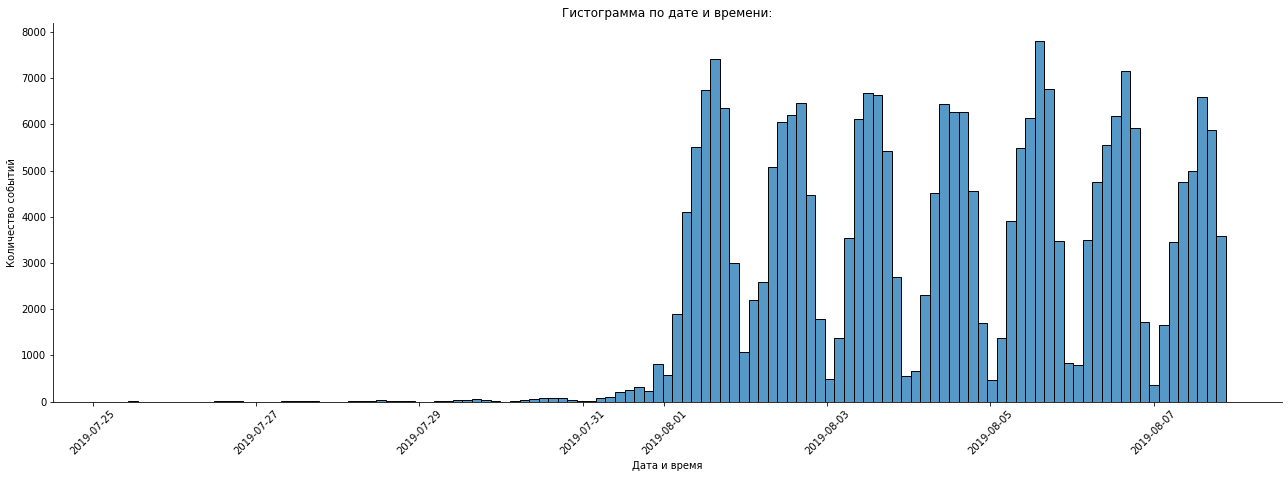

In [22]:

sns.displot(data['event_time_stamp'], height= 6 , aspect= 3)
plt.title('Гистограмма по дате и времени:')
plt.ylabel('Количество событий')
plt.xlabel('Дата и время')
plt.xticks(rotation = 45)
plt.show()

По графику можно сделать вывод, что мы не располагаем одинаково полными данными за весь период. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». По графику это отчетливо видно, это логи до 2019-08-01. Отбросим более старые данные

In [23]:
data_new = data.query('event_date >= @pd.Timestamp(2019,8,1)')

In [24]:
data_new['event_date'].agg(['min', 'max'])

min    2019-08-01
max    2019-08-07
Name: event_date, dtype: object

### Данные после фильтрации

In [25]:
print('Потеряно событий {:.2%}'.format(1-len(data_new)/len(data)))

Потеряно событий 1.16%


In [26]:
print('Потеряно пользователей {:.2%}'.format(1-len(data_new['device_id_hash'].unique())/len(data['device_id_hash'].unique())))

Потеряно пользователей 0.23%


In [27]:
data_new['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

У нас есть пользователи из всех трёх экспериментальных групп, посмотрим сколько уникальных пользователей в каждой из групп

In [28]:
unique_users = data.pivot_table(index=['group'], values=['device_id_hash'], aggfunc=['nunique']).reset_index()
unique_users.columns = ['group', 'count']
unique_users

,group,count
0,246,2489
1,247,2520
2,248,2542


Вывод: Мы располагаем данными с 27 июля по 7 августа 2019 года. По гистограмме частоты событий видим, что новые полные данные мы начали получать только с 1 августа 2019 г, отбросили данные, полученные раньше. Мы потеряли 1.16% событий и 0,23% пользователей, что не повлияет на результаты анализа, у нас есть пользователи из всех трех экспериментальных групп.

### Анализ воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [29]:
events=data_new['event_name'].value_counts().reset_index()
events.columns=['event_name','count']
events

,event_name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


наиболее распространенным в логах является событие 'MainScreenAppear'.

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [30]:
count_event = data_new.groupby('event_name').agg({'device_id_hash':'nunique'}).sort_values(by = 'device_id_hash', ascending = False).reset_index()
count_event['share'] = count_event['device_id_hash']/len(data_new['device_id_hash'].unique())
count_event['share']*=100
count_event.style.format({'share': '{:.2f}%'})

,event_name,device_id_hash,share
0,MainScreenAppear,7419,98.47%
1,OffersScreenAppear,4593,60.96%
2,CartScreenAppear,3734,49.56%
3,PaymentScreenSuccessful,3539,46.97%
4,Tutorial,840,11.15%


<AxesSubplot:xlabel='event_name', ylabel='device_id_hash'>

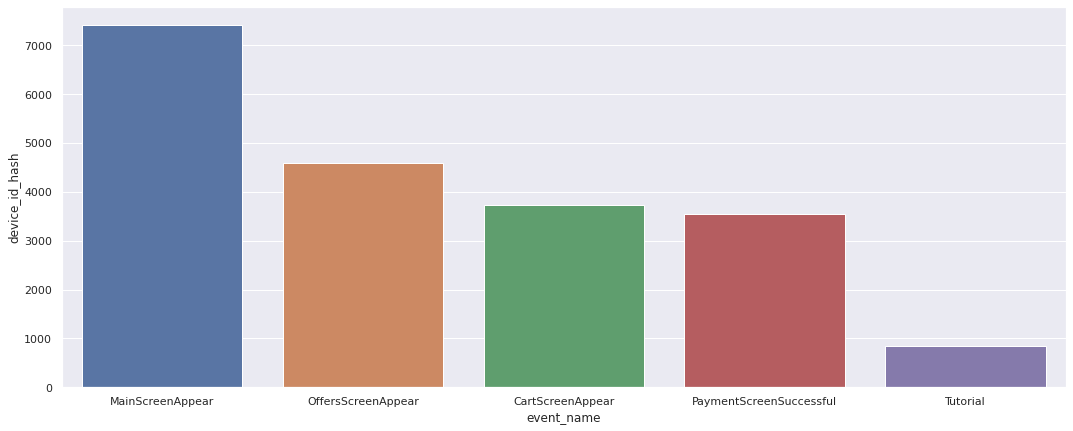

In [31]:
sns.set(rc={'figure.figsize':(18, 7)})
sns.barplot(data=count_event, x=count_event['event_name'], y=count_event['device_id_hash'])

Предположу, что события идут в таком порядке: 

0. Обучающий материал по пользованию приложения (Tutorial)
1. Появление главного экрана (MainScreenAppear)
2. Появляение экрана предложений (OffersScreenAppear)
3. Появление экрана корзины (CartScreenAppear)
4. Появление экрана с информацией об успешно выполненном платеже (PaymentScreenSuccessful)

Все выстраиваются в последовательную цепочку, кроме Tutorial, не будем учитывать эти логи при расчете воронки, так как это не обязательный пункт, его можно пройти в любое время.



In [32]:
count_event=count_event.drop(labels = [4],axis = 0)

In [33]:
funel=count_event['device_id_hash']. tolist ()

In [34]:
g=[100]
for i in range(0, len(funel)-1):
    a=(funel[i+1]/funel[i])*100
    g.append(a)

In [35]:
c=[]
for i in range(0, len(funel)):
    b=(funel[i]/funel[0])*100
    c.append(b)

In [36]:
funel= pd.Series(g)
count_event['funel']=funel

In [37]:
conversion=pd.Series(c)
count_event['total_conversion']=conversion


In [38]:
count_event.style.format({'funel': '{:.2f}%', 'total_conversion': '{:.2f}%'})

,event_name,device_id_hash,share,funel,total_conversion
0,MainScreenAppear,7419,98.473586,100.00%,100.00%
1,OffersScreenAppear,4593,60.963632,61.91%,61.91%
2,CartScreenAppear,3734,49.561986,81.30%,50.33%
3,PaymentScreenSuccessful,3539,46.973719,94.78%,47.70%


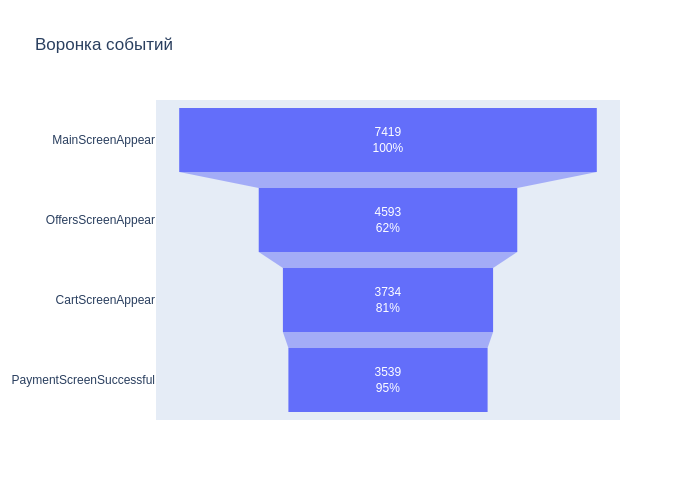

In [39]:
fig = go.Figure(go.Funnel(
    y = count_event['event_name'],
    x = count_event.device_id_hash,
    textinfo = "value+percent previous"
    ),
    layout=go.Layout(
        title=go.layout.Title(text="Воронка событий")
    ))
fig.show() 

Вывод: больше всего пользователей (38.1%) теряется на первом шаге при переходе от события 'MainScreenAppear' к событию 'OffersScreenAppear'; Доля пользователей, перешедших к оплате от получивших предложение 0.81, доля пользователей, оплативших товар от перешедших к оплате 0.95.

от первого события до оплаты доходит 48% пользователей.


## Анализ A/B-теста

узнаем сколько пользователей в каждой из групп

In [40]:
data_new.groupby('group').agg({'device_id_hash':'nunique'})

,device_id_hash
group,
246,2484
247,2513
248,2537


Вывод:Количество пользователей в группах

- Экспериментальная группа 248 - 2537
- Контрольная группа 246 - 2484
- Контрольная группа 247 - 2513

### Проверка разницы между выборками 

Проверим, находят ли статистические критерии разницу между выборками двух контрольных групп А/А-эксперимента.

Сформулируем гипотезы:

H0: доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

H1: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

Критический уровень статистической значимости: alpha = 0.05

Рассчитаем статистическую значимость различий между выборками

In [41]:
funnel_group = (data_new.
          groupby(['event_name', 'group']).
          agg({'device_id_hash': 'nunique'}).
          reset_index().
          rename(columns={'device_id_hash' : 'total_users'}).
          sort_values(by=['group','total_users'], ascending=False))

funnel_group = funnel_group[funnel_group['event_name'] != 'Tutorial']
funnel_group

,event_name,group,total_users
5,MainScreenAppear,248,2493
8,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1230
11,PaymentScreenSuccessful,248,1181
4,MainScreenAppear,247,2476
7,OffersScreenAppear,247,1520
1,CartScreenAppear,247,1238
10,PaymentScreenSuccessful,247,1158
3,MainScreenAppear,246,2450
6,OffersScreenAppear,246,1542


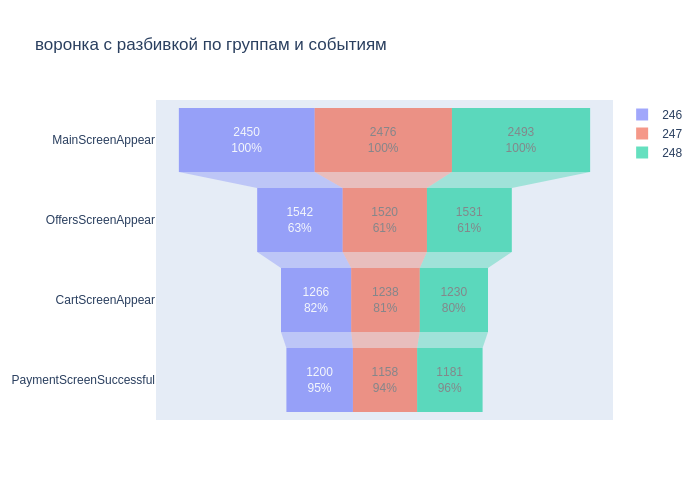

In [42]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = '246',
                        y = funnel_group.query('group == 246')['event_name'],
                        x = funnel_group.query('group == 246')['total_users'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))

fig.add_trace(go.Funnel(name = '247',
                        y = funnel_group.query('group == 247')['event_name'],
                        x = funnel_group.query('group == 247')['total_users'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))


fig.add_trace(go.Funnel(name = '248',
                        y = funnel_group.query('group == 248')['event_name'],
                        x = funnel_group.query('group == 248')['total_users'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))
                        
fig.update_layout(title_text='воронка с разбивкой по группам и событиям')
fig.show()


In [43]:

A1_group = data_new.query("group==246").groupby('event_name').agg({'device_id_hash':'nunique'})
A2_group = data_new.query("group==247").groupby('event_name').agg({'device_id_hash':'nunique'})
B_group = data_new.query("group==248").groupby('event_name').agg({'device_id_hash':'nunique'})


In [44]:
A1_group

,device_id_hash
event_name,
CartScreenAppear,1266
MainScreenAppear,2450
OffersScreenAppear,1542
PaymentScreenSuccessful,1200
Tutorial,278


In [45]:
A1_group.loc['all']=len(data_new.query("group==246")['device_id_hash'].unique())
A2_group.loc['all']=len(data_new.query("group==247")['device_id_hash'].unique())
B_group.loc['all']=len(data_new.query("group==248")['device_id_hash'].unique())


Всего у нас 4 вида событий, 4 A/A теста и 12 А/В, следовательно для всех тестов мы вводим поправку Бонферрони bonferroni_alpha = alpha / 16

Для всех проверок уровень статистической значимости должен быть постоянным, так как гипотезы проверяются по данным одной выборки, поэтому для А/А теста нужно применить поправку Бонферрони.

In [46]:
def z_test(group_one, 
           group_two,
           event_trials,
           event_successes,
           alpha = 0.05/16):

    successes = np.array([int(group_one.loc[event_successes]), int(group_two.loc[event_successes])])
    trials =  np.array([int(group_one.loc[event_trials]),int(group_two.loc[event_trials])])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие', event_successes)

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница\n')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n'
        ) 


In [47]:
z_test(A1_group, A2_group, 'all', 'MainScreenAppear')

Событие MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [48]:
z_test(A1_group, A2_group, 'all', 'OffersScreenAppear')

Событие OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [49]:
z_test(A1_group, A2_group, 'all', 'CartScreenAppear')

Событие CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [50]:
z_test(A1_group, A2_group, 'all', 'PaymentScreenSuccessful')

Событие PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



разбиение на группы A1 A2 корректно, нет причин отвергать нулевую гипотезу и считать, что между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница. Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.

Внесем коррективы при выборе уровня значимости, учитывая множественные проверки и воспользуемся поправкой Бонферрони.

Всего у нас 4 вида событий, 4 A/A теста и 12 А/В, следовательно для всех тестов мы вводим поправку Бонферрони bonferroni_alpha = alpha / 16

In [51]:
def z_test_events(group_one, group_two, alpha = 0.05/16):
    z_test(group_one, group_two, 'all', 'MainScreenAppear', alpha)
    z_test(group_one, group_two, 'all', 'OffersScreenAppear', alpha)
    z_test(group_one, group_two, 'all', 'CartScreenAppear', alpha)
    z_test(group_one, group_two, 'all', 'PaymentScreenSuccessful', alpha)


In [52]:
z_test_events(A1_group, B_group)

Событие MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При заданном уровне значимости у нас нет оснований считать группы 246 и 248 разными.

In [53]:
z_test_events(A2_group, B_group)

Событие MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При заданном уровне значимости у нас нет оснований считать группы 247 и 248 разными.

проверим есть ли статистически значимая разница между объединённой контрольной и экпериментальной 248 группами:

In [54]:
AA_group = A1_group+A2_group

In [55]:
z_test_events(AA_group, B_group)

Событие MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Различия в группах не значимы, эксперимент по изменению шрифта не дал заметной разницы в поведении пользователей.

In [56]:
z_test_events(AA_group, B_group, alpha = 0.1/16)

Событие MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Все также, группы нельзя считать разными. Это отзначает, что изменение шрифтов во всём приложении на поведение пользователей не повлияло.

Проверили возможность использования уровня значимости 0.1, получаем не значимые различия групп. 

## Вывод

Мы загрузили данные и изучили общую информацию, типы данных верные, кроме столбца с датой, пропуски отсутствуют. Для удобства были переименованы столбцы, добавлен столбец даты. Было найдено 413 дубликатов, которые принято решение удалить.

Мы располагаем данными с 27 июля по 7 августа 2019 года. По гистограмме частоты событий видим, что полные данные мы начали получать только с 1 августа 2019 г, отбросили данные, полученные раньше. Мы потеряли около 1% событий и 0,23% пользователей, что не повлияет на результаты анализа, у нас по прежнему есть пользователи из всех трех экспериментальных групп.

Мы посмотрели события в логах, порядок событий:

0. Обучающий материал по пользованию приложения (Tutorial)
1. Появление главного экрана (MainScreenAppear)
2. Появляение экрана предложений (OffersScreenAppear)
3. Появление экрана корзины (CartScreenAppear)
4. Появление экрана с информацией об успешно выполненном платеже (PaymentScreenSuccessful)

Все выстраиваются в последовательную цепочку, кроме Tutorial, не будем учитывать эти логи при расчете воронки, так как это не обязательный пункт, его можно пройти в любое время.

Дошли до последнего шага нашей воронки - оплатили товар только 46% все пользователей. По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки. Наибольшие потери пользвателей на шаге перехода от главного экрана к получению предложения, доходят только 62%. Доля пользователей, перешедших к оплате от получивших предложение 81%, доля пользователей, оплативших товар от перешедших к оплате 95%.

Мы изучили результаты эксперимента. С помощью z теста была проверена корректность разбиения на группы. Отличия между группами не являются статистически достоверными, разбиение на группы корректно. Аналогично поступили с группой с изменённым шрифтом и объединенной контрольной группой. Различия в группах не значимы, эксперимент по изменению шрифта не дал заметной разницы в поведении пользователей.

Изменение шрифтов в приложении не окажет влияния на воронку событий приложения.